# Result analysis

## Loss

In [1]:
import glob
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from bouncing_ball.dataloaders.bouncing_data import BouncingBallDataLoader
from kalman_vae import KalmanVariationalAutoencoder
from natsort import natsorted
from sample_control import SampleControl
from torch.utils.data import DataLoader

In [2]:
dtype = torch.float64
device = torch.device("cpu")

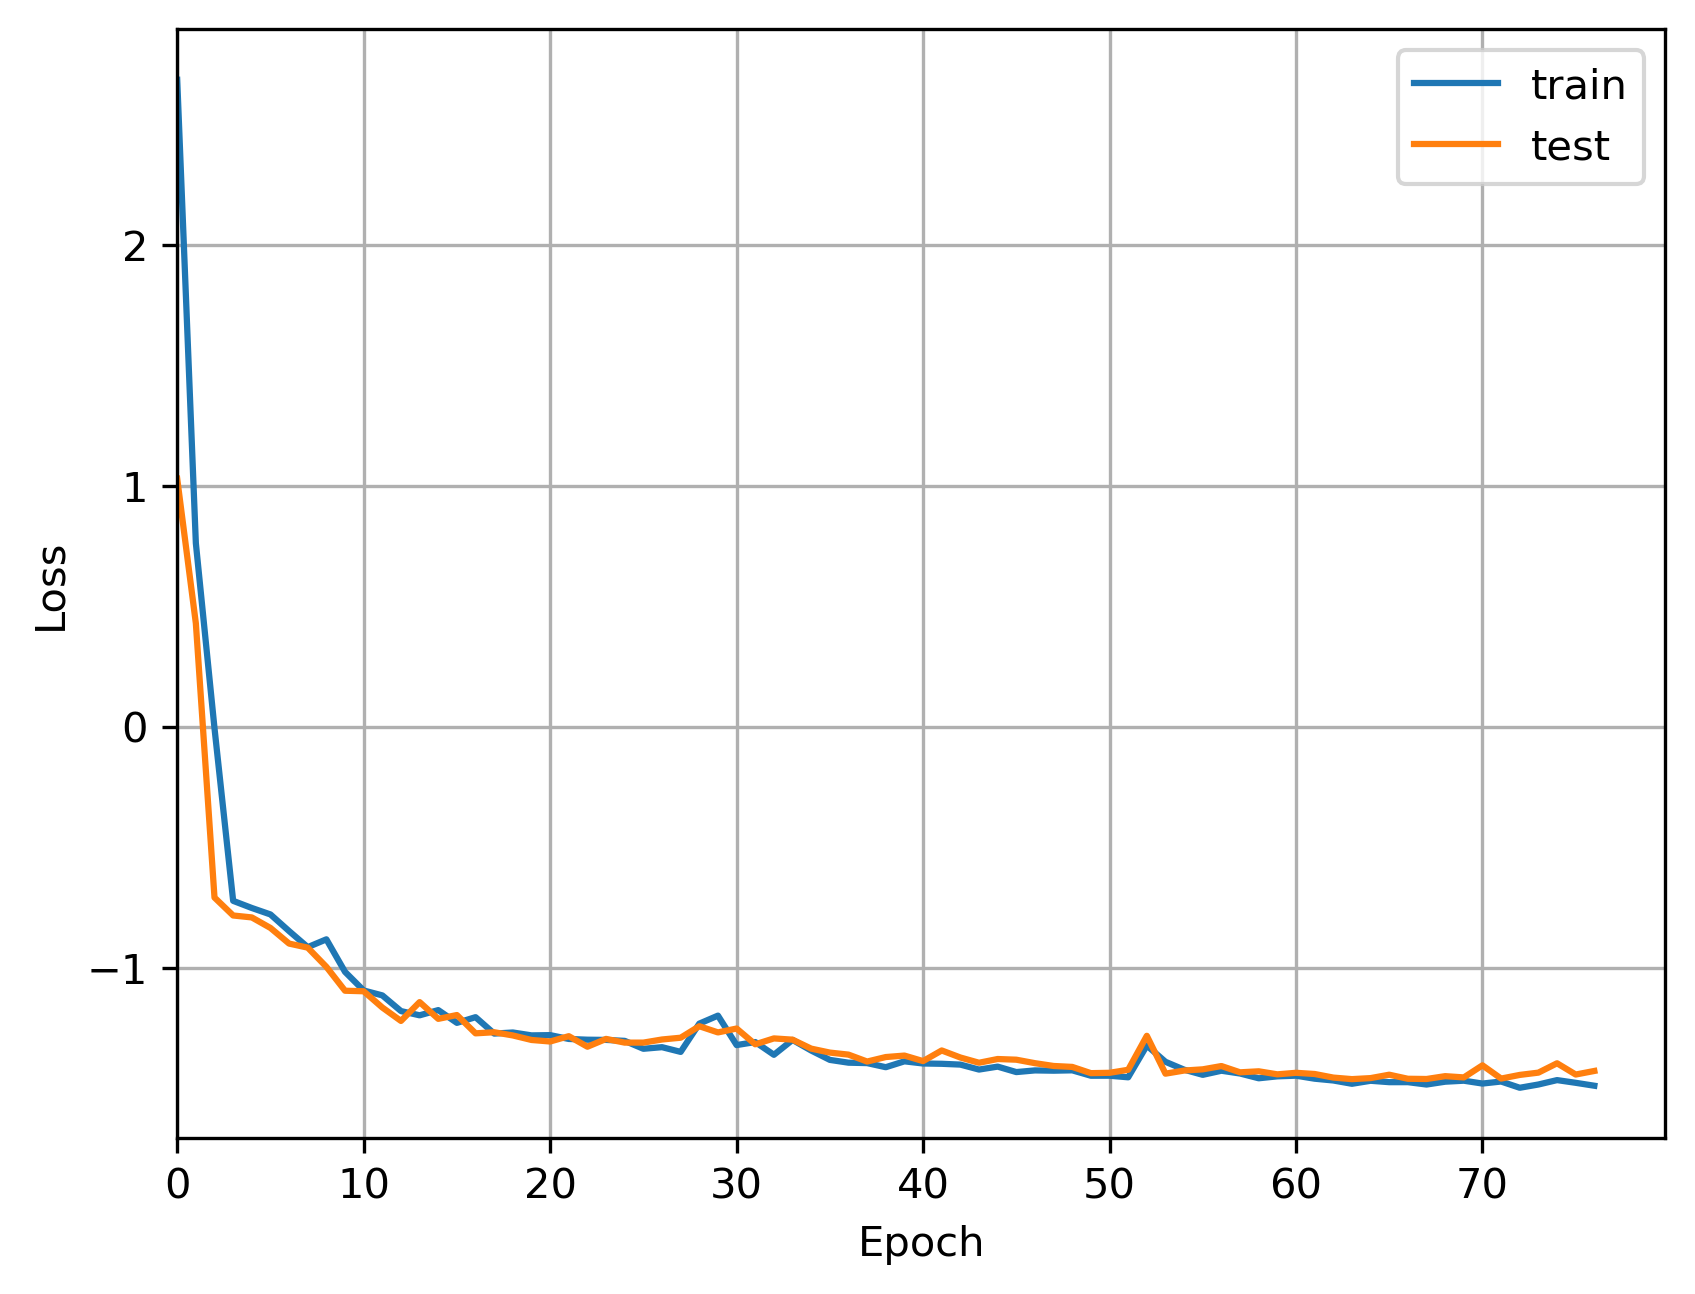

In [3]:
train_losses = []
test_losses = []


plt.figure(dpi=300)

train_losses = []
test_losses = []

for file in natsorted(
    glob.glob(
        f"checkpoints/bouncing_ball_wo-vae_dtype-torch.float64_warmup-5_burnin-10_/state-*.pth"
    )
):
    checkpoint = torch.load(file, map_location=device)
    train_losses.append(checkpoint["train_loss"])
    test_losses.append(checkpoint["test_loss"])

plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.xlim(0, None)
# plt.yscale("log")
plt.show()

In [4]:
checkpoint_10 = torch.load("checkpoints/bouncing_ball_wo-vae_dtype-torch.float64_warmup-10_burnin-3/state-15.pth")
checkpoint_0 = torch.load("checkpoints/bouncing_ball_wo-vae_dtype-torch.float64_warmup-10_burnin-3/state-0.pth")

In [5]:
keys = checkpoint_10["model_state_dict"].keys()

In [6]:
for key in keys:
    diff = ((checkpoint_10["model_state_dict"][key] - checkpoint_0["model_state_dict"][key])**2).sum()
    print(key, diff)

_zero_val tensor(0., device='cuda:0', dtype=torch.float64)
encoder.conv1.weight tensor(0., device='cuda:0', dtype=torch.float64)
encoder.conv1.bias tensor(0., device='cuda:0', dtype=torch.float64)
encoder.conv2.weight tensor(0., device='cuda:0', dtype=torch.float64)
encoder.conv2.bias tensor(0., device='cuda:0', dtype=torch.float64)
encoder.conv3.weight tensor(0., device='cuda:0', dtype=torch.float64)
encoder.conv3.bias tensor(0., device='cuda:0', dtype=torch.float64)
encoder.fc_mean.weight tensor(0., device='cuda:0', dtype=torch.float64)
encoder.fc_mean.bias tensor(0., device='cuda:0', dtype=torch.float64)
encoder.fc_std.weight tensor(0., device='cuda:0', dtype=torch.float64)
encoder.fc_std.bias tensor(0., device='cuda:0', dtype=torch.float64)
decoder.fc.weight tensor(0., device='cuda:0', dtype=torch.float64)
decoder.fc.bias tensor(0., device='cuda:0', dtype=torch.float64)
decoder.deconv1.weight tensor(0., device='cuda:0', dtype=torch.float64)
decoder.deconv1.bias tensor(0., device='c

## Weights for transition matrix $A$

In [7]:
checkpoint = torch.load(file, map_location=device)

In [8]:
kvae = KalmanVariationalAutoencoder(
    image_size=(16, 16),
    image_channels=1,
    a_dim=2,
    z_dim=4,
    K=3,
    decoder_type="bernoulli",
).to(device=device, dtype=dtype)

In [9]:
kvae.load_state_dict(checkpoint["model_state_dict"], strict=False)

<All keys matched successfully>

In [10]:
_dataloader_test = BouncingBallDataLoader(
    root_dir="bouncing_ball/datasets/bouncing-ball/test"
)

In [11]:
x_tensor = torch.linspace(-2, 2, 16)
y_tensor = torch.linspace(2, -2, 16)

In [12]:
def sequence_first_collate_fn(batch):
    data = torch.Tensor(np.stack(batch, axis=0))
    # data.shape: [batch size, sequence length, channels, height, width]
    # Reshape to [sequence length, batch size, channels, height, width]
    data = data.permute(1, 0, 2, 3, 4)
    weight_x = data.mean(-1)
    weight_x = (weight_x / weight_x.sum(-1).unsqueeze(-1)).squeeze(-2)
    weight_y = data.mean(-2)
    weight_y = (weight_y / weight_y.sum(-1).unsqueeze(-1)).squeeze(-2)
    
    data_x = (weight_x * x_tensor).sum(-1)
    data_y = (weight_y * y_tensor).sum(-1)

    return torch.stack([data_x, data_y], dim=-1)

In [13]:
dataloader_test = DataLoader(
    _dataloader_test, batch_size=128, shuffle=True, collate_fn=sequence_first_collate_fn
)

In [14]:
for i, data_batch in enumerate(dataloader_test):
    data_batch = data_batch.to(device=device, dtype=dtype)
    break

In [15]:
seq_length = data_batch.shape[0]
batch_size = data_batch.shape[1]

In [16]:
weights = kvae.state_space_model.weight_model(data_batch)

In [17]:
_ = [os.remove(f) for f in glob.glob("analysis/weight-*.png")]

In [18]:
for step, (data, weight) in enumerate(
    zip(data_batch[:, 0],weights[:, 0])
):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(f"$t = {step}$")
    axes[0].plot(data[0], data[1], "o")
    axes[0].set_adjustable("box")
    axes[0].set_xlim(-2, 2)
    axes[0].set_ylim(-2, 2)
    axes[1].bar(["0", "1", "2"], weight.detach().numpy())
    axes[1].set_ylim(0, 1)
    axes[0].set_title(r"data $\mathbf{a}_t$")
    axes[1].set_title(r"weight $\mathbf{k}_t$")
    pos_img = axes[0].get_position()
    pos_bar = axes[1].get_position()
    axes[1].set_position([pos_bar.x0, pos_img.y0, pos_bar.width, pos_img.height])
    fig.savefig(f"analysis/weight-{step}.png")
    plt.close()

In [19]:
!ffmpeg -framerate 10 -i analysis/weight-%d.png -c:v libopenh264 -r 30 -pix_fmt yuv420p analysis/weights.mp4 -y

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-gnu

In [20]:
from IPython.display import Video

Video("./analysis/weights.mp4")

## Future prediction

In [ ]:
sample_control_eval = SampleControl.training_defaults()

In [ ]:
sample_control_eval

In [ ]:
x_pred, pred_info = kvae.predict_future(
    (data_batch > 0.5).to(dtype=dtype),
    sample_control=sample_control_eval,
    num_steps=150,
)

In [ ]:
pred_info.keys()

In [ ]:
as_ = pred_info["as"]
weights = kvae.state_space_model.weight_model(as_)
reconstructions = kvae.decoder(as_).probs

In [ ]:
for step, (image, reconstruction, weight) in enumerate(
    zip(x_pred, reconstructions.detach().numpy(), weights)
):
    image = image > 0.5
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    if step < seq_length:
        axes[0].imshow(image[0][0], vmin=0, vmax=1, cmap="Greys", aspect="equal")
        fig.suptitle(f"$t = {step}$", color="black")
    if step >= seq_length:
        axes[0].imshow(image[0][0] * 0.0, vmin=0, vmax=1, cmap="Greys", aspect="equal")
        fig.suptitle(f"$t = {step}$ (prediction)", color="red")
    axes[0].set_adjustable("box")
    axes[1].imshow(reconstruction[0], vmin=0, vmax=1, cmap="Greys", aspect="equal")
    axes[2].bar(["0", "1", "2"], weight[0].detach().numpy())
    axes[2].set_ylim(0, 1)
    axes[0].set_title(r"image $\mathbf{x}_t$")
    axes[1].set_title(r"reconstruction $\hat{\mathbf{x}}_t$")
    axes[2].set_title(r"weight $\mathbf{k}_t$")
    pos_img = axes[0].get_position()
    pos_bar = axes[2].get_position()
    axes[2].set_position([pos_bar.x0, pos_img.y0, pos_bar.width, pos_img.height])
    fig.savefig(f"analysis/weight-{step}.png")
    plt.close()

In [ ]:
!ffmpeg -framerate 30 -i analysis/weight-%d.png -c:v libopenh264 -r 30 -pix_fmt yuv420p analysis/weights.mp4 -y

In [ ]:
Video("./analysis/weights.mp4")

# Interpolation

In [ ]:
_dataloader_test = BouncingBallDataLoader(
    root_dir="bouncing_ball/datasets/bouncing-ball/test"
)


def sequence_first_collate_fn(batch):
    data = torch.Tensor(np.stack(batch, axis=0))
    # data.shape: [batch size, sequence length, channels, height, width]
    # Reshape to [sequence length, batch size, channels, height, width]
    data = data.permute(1, 0, 2, 3, 4)
    return data


dataloader_test = DataLoader(
    _dataloader_test, batch_size=128, shuffle=True, collate_fn=sequence_first_collate_fn
)

In [ ]:
kvae.eval()
for i, data in enumerate(dataloader_test):
    data = (data > 0.5).to(dtype=dtype).to(device)
    elbo, info = kvae.elbo(
        data,
        sample_control=SampleControl.training_defaults(),
    )
    break

In [ ]:
for idx in range(10):
    plt.plot(info["filter_as"][:, 0, idx, 0].cpu().detach().numpy(), info["filter_as"][:, 0, idx, 1].cpu().detach().numpy(), "o-")
plt.xlim(-70, 70)
plt.ylim(-70, 70)
plt.grid()
plt.gca().set_aspect("equal")

In [ ]:
info.keys()

In [ ]:
torch.linalg.svd(info["covariances"][1]).S

-> very anisotropic

In [ ]:
torch.linalg.svd(info["mat_As"][0]).S

In [ ]:
torch.linalg.svd(info["mat_Cs"][1]).S